In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from pathlib import Path
proj_dir = str(Path.cwd())

In [20]:
all_stocks_path = proj_dir + "\\data\\historical\\"
tata_motors = all_stocks_path + "TATAMOTORS#AUTOMOBILE.csv"
df = pd.read_csv(tata_motors)

In [21]:
try:
    df.drop(['Unnamed: 0'], axis = 1, inplace = True)
except:
    pass

try:
    df.set_index('Date', inplace = True)
    df.dropna(inplace = True)
except:
    pass
df

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,ema20,ema50,ema100,ema200,rsi,macd,signal,volatility50,volatility5,volatility10,volatility20
Date,,,,,,,,,,,,,,,,,,,
2000-05-29,118.75,118.80,128.25,118.80,122.20,122.90,124.72,1474009,129.550064,135.784505,144.214350,151.108294,41.042139,-2.934778,-1.649681,0.287655,0.082378,0.087115,0.147266
2000-05-30,122.90,120.10,123.85,116.55,122.50,122.80,121.37,912163,128.907175,135.266192,143.725453,150.665259,40.950375,-3.101577,-1.940060,0.276800,0.083101,0.082431,0.146982
2000-05-31,122.80,128.50,129.00,123.15,123.50,124.30,126.09,1001574,128.468380,134.828754,143.283302,150.254972,43.008753,-3.077376,-2.167523,0.274082,0.084637,0.083598,0.147327
2000-06-01,124.30,124.00,125.00,121.00,122.55,122.35,123.55,313592,127.885658,134.331315,142.808237,149.823147,41.007512,-3.178742,-2.369767,0.263655,0.051635,0.082147,0.144788
2000-06-02,122.35,123.10,125.90,115.55,119.25,118.85,121.15,1535065,127.025093,133.714584,142.266090,149.346477,37.623586,-3.500877,-2.595989,0.262861,0.055003,0.084581,0.120368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,311.85,312.45,313.90,302.15,302.60,304.50,308.00,57723298,306.305655,263.232573,220.383577,183.866296,54.328190,19.806452,25.417632,0.288616,0.033395,0.062520,0.198182
2021-02-23,304.50,308.50,328.90,308.50,324.60,324.00,319.80,133310157,307.990831,265.615610,222.435387,185.260661,61.385259,18.925430,24.119192,0.293100,0.087866,0.089741,0.202348
2021-02-24,324.00,325.00,330.00,316.50,321.20,321.65,324.47,50821757,309.291704,267.813037,224.400033,186.617769,60.178460,17.832031,22.861760,0.293136,0.087576,0.088905,0.196131


In [22]:
try:
    df.drop(['Open', 'High', 'Low', 'Prev Close', 'VWAP', 'Last'], axis=1, inplace=True)
except:
    pass

df

,Close,Volume,ema20,ema50,ema100,ema200,rsi,macd,signal,volatility50,volatility5,volatility10,volatility20
Date,,,,,,,,,,,,,
2000-05-29,122.90,1474009,129.550064,135.784505,144.214350,151.108294,41.042139,-2.934778,-1.649681,0.287655,0.082378,0.087115,0.147266
2000-05-30,122.80,912163,128.907175,135.266192,143.725453,150.665259,40.950375,-3.101577,-1.940060,0.276800,0.083101,0.082431,0.146982
2000-05-31,124.30,1001574,128.468380,134.828754,143.283302,150.254972,43.008753,-3.077376,-2.167523,0.274082,0.084637,0.083598,0.147327
2000-06-01,122.35,313592,127.885658,134.331315,142.808237,149.823147,41.007512,-3.178742,-2.369767,0.263655,0.051635,0.082147,0.144788
2000-06-02,118.85,1535065,127.025093,133.714584,142.266090,149.346477,37.623586,-3.500877,-2.595989,0.262861,0.055003,0.084581,0.120368
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,304.50,57723298,306.305655,263.232573,220.383577,183.866296,54.328190,19.806452,25.417632,0.288616,0.033395,0.062520,0.198182
2021-02-23,324.00,133310157,307.990831,265.615610,222.435387,185.260661,61.385259,18.925430,24.119192,0.293100,0.087866,0.089741,0.202348
2021-02-24,321.65,50821757,309.291704,267.813037,224.400033,186.617769,60.178460,17.832031,22.861760,0.293136,0.087576,0.088905,0.196131


In [23]:
df = df.tail(1000)


In [24]:
close_scaler = RobustScaler()
close_scaler.fit(df[['Close']])
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
print(df['Close'].min(), df['Close'].max())

-0.5568713534746694 1.3665299520536076


In [25]:
df.tail()

,Close,Volume,ema20,ema50,ema100,ema200,rsi,macd,signal,volatility50,volatility5,volatility10,volatility20
Date,,,,,,,,,,,,,
2021-02-22,0.548553,0.986951,0.509552,0.286922,0.090379,-0.169195,0.321498,2.117507,2.807020,0.960231,-0.330460,-0.161072,1.149554
2021-02-23,0.638669,2.916150,0.516804,0.296403,0.098247,-0.163823,0.675393,2.030132,2.673028,1.005332,1.070564,0.348889,1.205373
2021-02-24,0.627809,0.810803,0.522403,0.305145,0.105780,-0.158594,0.614875,1.921694,2.543267,1.005694,1.063110,0.333241,1.122080
2021-02-25,0.680954,1.160293,0.532182,0.315339,0.114038,-0.152977,0.802349,1.907563,2.436518,1.014460,1.212109,0.455219,1.138568
2021-02-26,0.633817,1.859275,0.536848,0.323542,0.121357,-0.147806,0.538577,1.795802,2.327860,1.045409,1.116711,0.563324,1.176228


<AxesSubplot:xlabel='Date'>

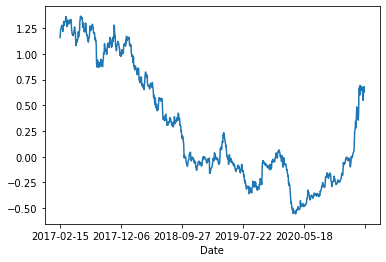

In [26]:
df['Close'].plot()

In [35]:
def split_sequence(seq, n_steps_in, n_steps_out):
    X, y = list(), list()
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]               # 0 for 'Close'. might try with RSI later
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [36]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [37]:
def create_layer(n_layers, n_nodes, activation, drop = None, d_rate = 0.5):
    for x in range(1, n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))
        try:
            if x%drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [38]:
def validator(n_per_in, n_per_out):
    predictions = pd.DataFrame(index=df.index, columns=df.columns[0])
    
    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        x = df[-i - n_per_in:-i]

        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))
        yhat = close_scaler.inverse_transform(yhat)[0]
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])
        predictions.update(pred_df)
        
    return predictions    

In [39]:
def val_rmse(df1, df2):
    df = df1.copy()
    df['close2'] = df2.Close
    df.dropna(inplace=True)
    df['diff'] = df.Close - df.close2
    rms = (df[['diff']]**2).mean()
    return float(np.sqrt(rms))

In [40]:
# How many periods looking back to learn
n_per_in  = 50
# How many periods to predict
n_per_out = 5

n_features = df.shape[1]
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)